**Table of contents**<a id='toc0_'></a>    
- [Fonctions](#toc1_)    
- [Exploration du jeu de données](#toc2_)    
  - [NaN par colonne](#toc2_1_)    
- [Objectifs](#toc3_)    
- [Additifs](#toc4_)    
- [Huile de palme](#toc5_)    
- [Packaging information](#toc6_)    
- [Métriques nutritionnelles](#toc7_)    
  - [Remplacement des valeurs éronnées](#toc7_1_)    
  - [Correction des duplicata dans product name](#toc7_2_)    
  - [Cohérence des métriques](#toc7_3_)    
    - [Les graisses](#toc7_3_1_)    
    - [Les sucres](#toc7_3_2_)    
    - [Nombre de NaN par indice](#toc7_3_3_)    
    - [Scale data](#toc7_3_4_)    
  - [Imputation des valeurs manquantes par KNN (la fonction prend en moyenne 15 minutes)](#toc7_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import math
import plotly.express as px
from scipy.spatial import ConvexHull
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import pickle

# <a id='toc1_'></a>[Fonctions](#toc0_)

In [2]:
def scaleVector(vec):
    mean = vec.mean()
    sd = vec.std()
    vec = vec.apply(lambda x : np.nan if math.isnan(x) else (x - mean)/sd)
    return vec

def dataFrameDuplicated(data, label, keep = False):
    return data[data[label].duplicated(keep=keep)]

def removeNonASCII(data, label):    
    # convert the float values to strings
    data[label] = data[label].astype(str)    
    # remove rows where the values in column A are not ASCII
    data = data.drop(data[~data[label].apply(lambda x: x.isascii())].index)
    # display the resulting dataframe
    return(data)

def sampleDataFrame(data, data_size):
    sample = np.random.randint(data.shape[0], size= int(data_size) )
    sampled_data = data.iloc[sample]
    return sampled_data

def splitDataFrame(data, train_size = 0.8):
    toPick = round((data.shape[0]*80)/100, 0)
    train = np.random.randint(data.shape[0], size= int(toPick) )
    test = range(0,data.shape[0])
    test = list(set(test) - set(train))
    train = data.iloc[train]
    test = data.iloc[test]
    return test, train

def splitDataArray(X, y, train_size = 0.8):
    from sklearn.model_selection import train_test_split
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size = train_size)
    return xtrain, xtest, ytrain, ytest

################################################################################
######### KNN Functions
################################################################################

def KNNTestNeighbors(X, Krange = range(2, 10)):
    from sklearn import neighbors
    from sklearn.cluster import KMeans
    intertia = []
    list(Krange)
    for i in Krange :
        kmeans = KMeans(n_clusters=i,n_init=1)
        kmeans.fit(X) 
        intertia.append(kmeans.inertia_)
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    ax.set_ylabel("intertia")
    ax.set_xlabel("n_cluster")
    ax = plt.plot(Krange, intertia)
    
def KNN(xtrain, ytrain,  n_neighbors):
    from sklearn import neighbors
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(xtrain, ytrain)
    print(1 - knn.score(xtrain,ytrain))
    return knn

def KNNPrediction(knn, xtest, ytest):
    # On récupère les prédictions sur les données test
    predicted = knn.predict(xtest)

    # On redimensionne les données sous forme d'images
    images = xtest.values.reshape((-1, 28, 28))

    # On selectionne un echantillon de 12 images au hasard
    select = np.random.randint(images.shape[0], size=12)

    # On affiche les images avec la prédiction associée
    fig,ax = plt.subplots(3,4)

    for index, value in enumerate(select):
        plt.subplot(3,4,index+1)
        plt.axis('off')
        plt.imshow(images[value],cmap=plt.cm.gray_r,interpolation="nearest")
        plt.title('Predicted: {}'.format( predicted[value]) )

    plt.show()    
    
    # on récupère les données mal prédites 
    misclass = (ytest != predicted)
    misclass_images = images[misclass,:,:]
    misclass_predicted = predicted[misclass]

    # on sélectionne un échantillon de ces images
    select = np.random.randint(misclass_images.shape[0], size=12)

    # on affiche les images et les prédictions (erronées) associées à ces images
    for index, value in enumerate(select):
        plt.subplot(3,4,index+1)
        plt.axis(off)
        plt.imshow(misclass_images[value],cmap=plt.cm.gray_r,interpolation="nearest")
        plt.title('Predicted: {}'.format(misclass_predicted[value]) )

    plt.show()

################################################################################
######### PCA Functions
################################################################################
def pareto(data) :

    from matplotlib.ticker import PercentFormatter

    import numpy as np

    y = list(data)

    x = range(len(data))

    ycum = np.cumsum(y)/sum(y)*100

    fig, ax = plt.subplots()

    ax.bar(x,y,color="yellow")

    ax2 = ax.twinx()

    ax2.plot(x,ycum, color="C1", marker="D", ms=7)

    ax2.axhline(y=80,color="r")

    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax.tick_params(axis="y", colors="C0")

    ax2.tick_params(axis="y", colors="C1")

    plt.ylim(0,110)

    plt.show()
    return fig

def biplot(pca, x_y, features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

def FactorialPlanes(X_projected, x_y, pca=None,  labels = None, clusters=None, alpha=1, figsize=[10,8],  marker=".", size = 10 ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sn.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

def pca(X, n_components = 5, x_y = (0,1), labels = None):
    mypca = PCA(n_components=n_components)
    mypca.fit(X)
    print("Valeurs de variance par axes: \n ", mypca.singular_values_)
    print("Pourcentages expliqué par axes: \n ", mypca.explained_variance_ratio_) 
    print("Bruit estimé lié à la covariance: \n ", mypca.noise_variance_)
    
    x = mypca.fit_transform(X)
    cos_sq = x**2 / np.sum(x**2, axis = 1)[:, np.newaxis]

    p1 = pareto(mypca.explained_variance_ratio_)
    plt.show(p1)
    p2 = biplot(mypca, x_y, labels)
    plt.show(p2)
    p3 = FactorialPlanes(x, x_y, pca=mypca, size = cos_sq)

    
    return mypca, p1, p2


# <a id='toc2_'></a>[Exploration du jeu de données](#toc0_)

In [3]:
data = pd.read_csv("data/data.csv", header = 0, sep= '\t', low_memory=False)
data

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320767,9948282780603,http://world-fr.openfoodfacts.org/produit/9948...,openfoodfacts-contributors,1490631299,2017-03-27T16:14:59Z,1491244498,2017-04-03T18:34:58Z,Tomato & ricotta,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,99567453,http://world-fr.openfoodfacts.org/produit/9956...,usda-ndb-import,1489059076,2017-03-09T11:31:16Z,1491244499,2017-04-03T18:34:59Z,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
320769,9970229501521,http://world-fr.openfoodfacts.org/produit/9970...,tomato,1422099377,2015-01-24T11:36:17Z,1491244499,2017-04-03T18:34:59Z,乐吧泡菜味薯片,Leba pickle flavor potato chips,50 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320770,9980282863788,http://world-fr.openfoodfacts.org/produit/9980...,openfoodfacts-contributors,1492340089,2017-04-16T10:54:49Z,1492340089,2017-04-16T10:54:49Z,Tomates aux Vermicelles,NaN,67g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(data.columns.tolist())

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

## <a id='toc2_1_'></a>[NaN par colonne](#toc0_)

Text(0.5, 1.0, 'Distribution de NaN par colonnes')

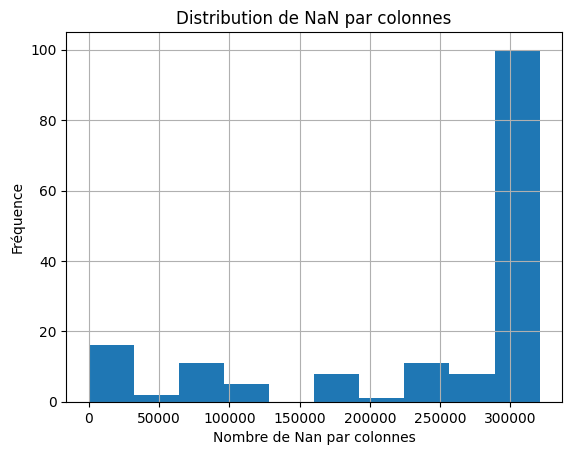

In [5]:
ax = data.isna().sum().hist()
ax.set_xlabel("Nombre de Nan par colonnes")
ax.set_ylabel("Fréquence")
ax.set_title("Distribution de NaN par colonnes")

On peut voir un grand nombre de colonnes avec beaucoup de NaN que l'on supprime par la moyenne

In [6]:
m = data.isna().sum().mean()
m

244497.46296296295

In [7]:
s = data.isna().sum()
s = pd.DataFrame(s)
data = data.loc[:,s[s.iloc[:,0] <= m].index]
data

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,1kg,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0,0.0
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320767,9948282780603,http://world-fr.openfoodfacts.org/produit/9948...,openfoodfacts-contributors,1490631299,2017-03-27T16:14:59Z,1491244498,2017-04-03T18:34:58Z,Tomato & ricotta,1,Plastique,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,99567453,http://world-fr.openfoodfacts.org/produit/9956...,usda-ndb-import,1489059076,2017-03-09T11:31:16Z,1491244499,2017-04-03T18:34:59Z,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",NaN,Plastique,...,0.0,0.00,0.00000,0.000,0.0,0.0000,0.000,0.00000,0.0,0.0
320769,9970229501521,http://world-fr.openfoodfacts.org/produit/9970...,tomato,1422099377,2015-01-24T11:36:17Z,1491244499,2017-04-03T18:34:59Z,乐吧泡菜味薯片,50 g,Plastique,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320770,9980282863788,http://world-fr.openfoodfacts.org/produit/9980...,openfoodfacts-contributors,1492340089,2017-04-16T10:54:49Z,1492340089,2017-04-16T10:54:49Z,Tomates aux Vermicelles,67g,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous sommes passés de 162 colonnes à 52.

In [8]:
print(data.columns.tolist())

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'serving_size', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr', 'main_category', 'main_category_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']


On peut voir que les colonnes de 0 à 8 contiennent des informations relatives au produit et à l'utilsateur. Les autres colonnes semblent avoir des métriques relatives au produit en question mais sont-elles toutes numériques?

In [9]:
with pd.option_context('display.max_rows', None):
    print(data.dtypes)

code                                        object
url                                         object
creator                                     object
created_t                                   object
created_datetime                            object
last_modified_t                             object
last_modified_datetime                      object
product_name                                object
quantity                                    object
packaging                                   object
packaging_tags                              object
brands                                      object
brands_tags                                 object
categories                                  object
categories_tags                             object
categories_fr                               object
countries                                   object
countries_tags                              object
countries_fr                                object
ingredients_text               

Non. Pour les colonnes contenant des objets et qui semblent les plus pertinentes, nous allons regarder en détail ce qu'elles contiennent.
Les colonnes suivantes sont écartées:
    - 'url', 'creator', 'created_t', 'created_datetime',

# <a id='toc3_'></a>[Objectifs](#toc0_)

**Après exploration des différentes colonnes on a:**
1. Les colonnes  'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', *states*, states_tags, states_fr, qui ne nous interessera pas pour le projet.
2. La colonne *code*  avec plusieurs catégories de lait ayant le même code, pour le moment on va garder cette structure mais potentiellement on pourrait créer un code unique pour chacun des types de lait ou alors un code unique pour le lait. On peut également voir que certaines informations ne correspond pas aux informatiosn requises telles que "France" dans la dernière ligne visible.
3. La colonne *product_name* avec les noms des produits.
4. La colonne *generic_name* qui a des caractères non latins qu'il faut enlever mais aussi des duplicata à fusionner. Elle complémente la colonne *product_name*.


5. La colonne *quantity* avec différentes unités de mesure et de décimales mais ce n'est pas si grave puisque l'on peut retourner à l'utilisateur la mesure telle quelle qui représente une unité" (par g, kg, unité, ml).


6. La colonne *packaging* qui na pas d'erreur majeure visible si ce n'est de multiples types en entrée. Cette colonne permettrait  de donner un score de recyclabilité du produit.
7. La colonne *packaging_tags* qui n'a pas d'erreur majeure visible et qui pourrait se combiner avec la colonne *packaging* pour avoir plus d'nformations.


8.  La colonne *brands* qui na pas d'erreur majeure visible et qui pourrait classifier les marques selon leur score nutritionnel et leur type d'emballage.
9.  La colonne *brands_tags* qui na pas d'erreur majeure visible et qui pourrait se combiner avec la colonne *brands*. 

10. La colonne *categories* qui na pas d'erreur majeure visible et qui pourrait catégoriser les différents produits.
11. La colonne *categories_tags* idem que la précédente
12. La colonne *ingredients_text* qui n'a pas d'erreur majeure visible et qui pourrait aider à mieux classifier les produits.


13. La colonne *additives_n* qui est un boolean qui permet de savoir s'il y a des additifs ou non.
14. La colonne *additives* complémente la colonne *additives_n*.
15. La colonne *additives_tags* complémente les colonnes  *additives_n*, *additives*.
16. La colonne *additives_fr* complémente les colonnes *additives_n*, *additives*, *additives_tags*.


17. La colonne *ingredients_from_palm_oil_n* qui est un boolean qui permet de savoir s'il y a de l'huile de palme
18.  La colonne *ingredients_that_may_be_from_palm_oil_n* qui est un indice qui permet de connaitre la probabilité d'avoir de l'huile de palme.


19. La colonne *nutrition_grade_fr* Score nutritionnel FR. La catégorisation est trop grossière alors qu'avec les métriques nutirtionnelles on pourrait avoir un score continu.


20. La colonne *pnns_groups_1* complémente les colonnes *categories*, *categories_tags*.
21. La colonne *pnns_groups_2* complémente les colonnes *categories*, *categories_tags*, *pnns_groups_1*.
22. La colonne *main_category* complémente les colonnes *categories*, *categories_tags*, *pnns_groups_1*, *pnns_groups_2*.
23. La colonne *main_category_fr* complémente les colonnes *categories*, *categories_tags*, *pnns_groups_1*, *pnns_groups_2*, *main_category*.


24. Les colonnes *energy_100g* jusqu'à *iron_100g* sont des métriques quantitatives.


25. Les colonnes *energy_100g*, *nutrition_score-fr_100g* et *nutrition_score-uk_100g* sont des scores nutritionnels continus qui seront meilleurs pour classer les aliments.

**L'objectif dans un premier temps est de séparer les informations en X types:**

1. Les métriques quantitatives pour pouvoir faire une score nutritionnel
2. Les informations de packaging combinées à la présence d'huile de palme pour une métrique 'écologique'
3. *In fine* l'application pourrait scanner un ingrédient, faire une fiche résumé avec ces trois valeurs

**Dans un deuxième temps selon le temps on peut immaginer une compilation du score nutritionnel pour une combinaison de produits dans l'optique d'évaluer un repas.**

**Dans un troisième temps on pourrait proposer une alternative au repas proposé**

On va commencer du plus simple au plus compliqué.


In [10]:
data.drop(['url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'states', 'states_tags', 'states_fr'], axis= 1,inplace=True)

# <a id='toc5_'></a>[Huile de palme](#toc0_)

In [11]:
empty = np.where(data['ingredients_from_palm_oil_n'].isnull() == True)[0]
for a in range(len(empty)):
    x = empty[a]
    if not math.isnan(data["ingredients_that_may_be_from_palm_oil_n"][x]):
        print("Extrat ingredients_from_palm_oil founds")


Pas d'information supplémentaire sur la présence ou non d'huile de palme. On va donc garder uniquement la colonne *ingredients_from_palm_oil_n*.

In [12]:
data.drop(["ingredients_that_may_be_from_palm_oil_n"], axis= 1,inplace=True)

In [13]:
PalmOil = open("PalmOil.pickle", "wb")
pickle.dump(data, PalmOil)
PalmOil.close()

# <a id='toc6_'></a>[Packaging information](#toc0_)

In [14]:
nonrecyclables = "plasti"
value = []
product = []
for a in range(len(data.packaging)):
    test = str(data.packaging[a]).lower()
    if test != "nan":
        if nonrecyclables in test:
            if data.packaging[a] == "plastic" or  data.packaging[a] == "plastique":
                value.append(0)
                product.append(data.product_name[a])
            else:
                value.append(0.5)
                product.append(data.product_name[a])
        else:
            value.append(1)
            product.append(data.product_name[a])
recyclability = pd.DataFrame([product,value])

In [15]:
recyclability = pd.DataFrame([product,value]).transpose()
recyclability.columns = ["product_name", "recyclability"]
recyclability

,product_name,recyclability
0,Filet de bœuf,0
1,Salade Cesar,1
2,Danoises à la cannelle roulées,1
3,Flute,0.5
4,Chaussons tressés aux pommes,1
...,...,...
78955,NaN,0.5
78956,Tomato & ricotta,0.5
78957,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",0.5
78958,乐吧泡菜味薯片,0.5


In [16]:
r = open("recyclability.pickle", "wb")
pickle.dump(recyclability, r)
r.close()

# <a id='toc7_'></a>[Métriques nutritionnelles](#toc0_)

In [17]:
data = removeNonASCII(data,"product_name")
data.reset_index(drop=True)

,code,product_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000004530,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0,14.0
1,0000000004559,Peanuts,NaN,NaN,NaN,Torn & Glasser,torn-glasser,NaN,NaN,NaN,...,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0,0.0
2,0000000016087,Organic Salted Nut Mix,NaN,NaN,NaN,Grizzlies,grizzlies,NaN,NaN,NaN,...,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
3,0000000016094,Organic Polenta,NaN,NaN,NaN,Bob's Red Mill,bob-s-red-mill,NaN,NaN,NaN,...,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000016100,Breadshop Honey Gone Nuts Granola,NaN,NaN,NaN,Unfi,unfi,NaN,NaN,NaN,...,7.7,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273643,99410148,nan,NaN,Plastique,plastique,NaN,NaN,Peanuts,"en:plant-based-foods-and-beverages,en:plant-ba...","Aliments et boissons à base de végétaux,Alimen...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273644,9948282780603,Tomato & ricotta,1,Plastique,plastique,Panzani,panzani,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273645,99567453,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",NaN,Plastique,plastique,Trader Joe's,trader-joe-s,NaN,NaN,NaN,...,0.0,0.00,0.00000,0.000,0.0,0.0000,0.000,0.00000,0.0,0.0
273646,9980282863788,Tomates aux Vermicelles,67g,NaN,NaN,Knorr,knorr,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
index = data.columns.str.contains("energy_100g").nonzero()[0][0]
metrics = data.iloc[:,[1]+ list(range(index, data.shape[1]))]
metrics

,product_name,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,Banana Chips Sweetened (Whole),2243.0,28.57,28.57,0.0,0.018,64.29,14.29,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0,14.0
2,Peanuts,1941.0,17.86,0.00,0.0,0.000,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0,0.0
3,Organic Salted Nut Mix,2540.0,57.14,5.36,NaN,NaN,17.86,3.57,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
4,Organic Polenta,1552.0,1.43,NaN,NaN,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Breadshop Honey Gone Nuts Granola,1933.0,18.27,1.92,NaN,NaN,63.46,11.54,7.7,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320766,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320767,Tomato & ricotta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",0.0,0.00,0.00,0.0,0.000,0.00,0.00,0.0,0.00,0.00000,0.000,0.0,0.0000,0.000,0.00000,0.0,0.0
320770,Tomates aux Vermicelles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On vérifie que toutes les colonnes sont bien de type numérique

In [19]:
metrics.dtypes

product_name                object
energy_100g                float64
fat_100g                   float64
saturated-fat_100g         float64
trans-fat_100g             float64
cholesterol_100g           float64
carbohydrates_100g         float64
sugars_100g                float64
fiber_100g                 float64
proteins_100g              float64
salt_100g                  float64
sodium_100g                float64
vitamin-a_100g             float64
vitamin-c_100g             float64
calcium_100g               float64
iron_100g                  float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
dtype: object

Toutes les colonnes sont pour 100g donc on enlève l'information.

In [20]:
#metrics.columns = metrics.columns.str.replace("_100g","")

In [21]:
metrics.min()

product_name                      
energy_100g                    0.0
fat_100g                       0.0
saturated-fat_100g             0.0
trans-fat_100g               -3.57
cholesterol_100g               0.0
carbohydrates_100g             0.0
sugars_100g                 -17.86
fiber_100g                    -6.7
proteins_100g               -800.0
salt_100g                      0.0
sodium_100g                    0.0
vitamin-a_100g            -0.00034
vitamin-c_100g             -0.0021
calcium_100g                   0.0
iron_100g                 -0.00026
nutrition-score-fr_100g      -15.0
nutrition-score-uk_100g      -15.0
dtype: object

In [22]:
metrics.iloc[:,1:].apply(lambda x: sum(x < 0))

energy_100g                    0
fat_100g                       0
saturated-fat_100g             0
trans-fat_100g                 4
cholesterol_100g               0
carbohydrates_100g             0
sugars_100g                    7
fiber_100g                     1
proteins_100g                  3
salt_100g                      0
sodium_100g                    0
vitamin-a_100g                 1
vitamin-c_100g                 1
calcium_100g                   0
iron_100g                      1
nutrition-score-fr_100g    30479
nutrition-score-uk_100g    31676
dtype: int64

In [23]:
metrics.max()

product_name               |mperial Mandarins
energy_100g                          231199.0
fat_100g                               714.29
saturated-fat_100g                      550.0
trans-fat_100g                          369.0
cholesterol_100g                       95.238
carbohydrates_100g                    2916.67
sugars_100g                            3520.0
fiber_100g                             5380.0
proteins_100g                           430.0
salt_100g                             64312.8
sodium_100g                           25320.0
vitamin-a_100g                           26.7
vitamin-c_100g                       716.9811
calcium_100g                          694.737
iron_100g                                50.0
nutrition-score-fr_100g                  40.0
nutrition-score-uk_100g                  40.0
dtype: object

In [24]:
metrics.iloc[:,1:].apply(lambda x: sum(x < 0))

energy_100g                    0
fat_100g                       0
saturated-fat_100g             0
trans-fat_100g                 4
cholesterol_100g               0
carbohydrates_100g             0
sugars_100g                    7
fiber_100g                     1
proteins_100g                  3
salt_100g                      0
sodium_100g                    0
vitamin-a_100g                 1
vitamin-c_100g                 1
calcium_100g                   0
iron_100g                      1
nutrition-score-fr_100g    30479
nutrition-score-uk_100g    31676
dtype: int64

On voit que certaines métriques ont des valeurs maximales inférieures à zéro. le nombre de valeurs est relativement faible au vu du nombre de lignes. On pourrait donc accepter la perte de ces produits. On peut aussi tenter d'inférer leurs valeurs en moyennant celles de produits ayant le même score *nutrition_grade_fr*.

## <a id='toc7_1_'></a>[Remplacement des valeurs éronnées](#toc0_)

In [25]:
metrics.iloc[:,1:]

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,2243.0,28.57,28.57,0.0,0.018,64.29,14.29,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0,14.0
2,1941.0,17.86,0.00,0.0,0.000,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0,0.0
3,2540.0,57.14,5.36,NaN,NaN,17.86,3.57,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
4,1552.0,1.43,NaN,NaN,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1933.0,18.27,1.92,NaN,NaN,63.46,11.54,7.7,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,0.0,0.00,0.00,0.0,0.000,0.00,0.00,0.0,0.00,0.00000,0.000,0.0,0.0000,0.000,0.00000,0.0,0.0
320770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
test = metrics.iloc[:,1:].apply(lambda x: np.where(x < 0))
test = test.iloc[:,:-2]
test

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
0,[],[],[],"[23484, 107590, 119949, 152679]",[],[],"[8548, 18150, 117024, 145480, 150046, 163190, ...",[23692],"[33678, 114622, 168273]",[],[],[80109],[41422],[],[270143]


In [27]:
for columns in test:
    if len(test[columns][0]) > 0:
        tmp = data.iloc[test[columns][0], data.columns.get_loc("nutrition_grade_fr")]
        for b in range(len(tmp)):            
            m = data[(data["nutrition_grade_fr"] == tmp.iloc[b]) & (data[columns] < 100)][columns].mean()  # On ne prend pas en compte les valeures supérieures à 100
            metrics.iloc[test[columns][0][b],metrics.columns.get_loc(columns)] = m

In [28]:
test = metrics.iloc[:,1:].apply(lambda x: np.where(x > 100))
test = test.iloc[:,:-2]
test.drop(columns = "energy_100g", inplace = True)
test

,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
0,"[112210, 259263, 261001]","[118655, 267446]","[11893, 81293, 81295, 120187, 137668]",[],"[70679, 73346, 111139, 119046, 132798, 154974,...","[111139, 132798, 154974, 192121, 213157, 22664...","[64209, 154974, 255798, 267446]",[267446],"[475, 1406, 3442, 7005, 7949, 11089, 18529, 18...","[1406, 7949, 11089, 20733, 21801, 23498, 51229...",[],"[131554, 138458, 148908]","[10455, 111853, 112514, 116362, 122921, 123383...",[]


In [29]:
for columns in test:
    if len(test[columns][0]) > 0:
        #tmp = data.loc[test[columns][0],"nutrition_grade_fr"].tolist()# Pour un raison que j'ignore ceci ne fonctionne pas
        tmp = data.iloc[test[columns][0], data.columns.get_loc("nutrition_grade_fr")]
        for b in range(len(tmp)):            
            m = data[(data["nutrition_grade_fr"] == tmp.iloc[b]) & (data[columns] < 100)][columns].mean()
            metrics.iloc[test[columns][0][b],metrics.columns.get_loc(columns)] = m

## <a id='toc7_2_'></a>[Correction des duplicata dans product name](#toc0_)
Maintenant que les métriques nutritionnelles sont corrigées on va pouvoir s'occuper des duplicata en calculant la moyenne de chaques métriques nutritionelles pour un produite dupliqué.

In [30]:
duplicata = dataFrameDuplicated(metrics, "product_name").product_name.unique()
print("Numbre of duplicata:", len(duplicata))
result = []
for a in range(len(duplicata)):
    tmp = metrics[metrics["product_name"] == duplicata[a]]
    ## On suprime les lignes dans data original
    tmp = tmp.iloc[:,1:]
    m = tmp.mean() # moyennes entre duplicata
    result.append([duplicata[a]] + m.values.tolist())
result = pd.DataFrame(columns=metrics.columns, data=result)
result

Numbre of duplicata: 21543


,product_name,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,Peanuts,2351.526316,42.199123,6.482281,0.0,0.0000,29.866842,12.814561,7.980357,22.200175,1.032337,0.406432,0.000028,0.004873,0.049611,0.002298,13.789474,13.789474
1,Organic Polenta,689.666667,0.305000,0.000000,0.0,0.0008,35.480000,0.400000,2.066667,2.695000,0.556768,0.219200,0.000054,0.004280,0.003200,0.000346,0.600000,0.600000
2,Organic Long Grain White Rice,1451.200000,0.277500,0.000000,0.0,0.0000,79.112000,0.000000,1.100000,7.114000,0.006985,0.002750,0.000000,0.000540,0.017600,0.000800,-1.500000,-1.500000
3,Organic Muesli,1715.500000,13.920000,3.255000,0.0,0.0000,62.540000,15.085000,8.350000,12.485000,0.104140,0.041000,NaN,NaN,0.062000,0.003420,2.500000,2.500000
4,Organic Sunflower Oil,3538.200000,97.334000,7.046000,0.0,0.0000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21538,Seafood Dumplings,838.000000,5.266667,2.466667,NaN,NaN,28.833333,1.066667,NaN,9.933333,1.094740,0.431000,NaN,NaN,NaN,NaN,4.333333,4.333333
21539,Lemon Lime & Bitters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21540,Flowers In Syrup,858.000000,0.000000,NaN,NaN,NaN,50.000000,45.450000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
21541,Crushed Apple Cider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Les autres produits qui n'étaitent pas des duplicata.

In [31]:
tmp = metrics[~metrics["product_name"].isin(result["product_name"])]
tmp = pd.concat([result, tmp])
tmp.reset_index()
tmp

,product_name,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,Peanuts,2351.526316,42.199123,6.482281,0.0,0.0000,29.866842,12.814561,7.980357,22.200175,1.032337,0.406432,0.000028,0.004873,0.049611,0.002298,13.789474,13.789474
1,Organic Polenta,689.666667,0.305000,0.000000,0.0,0.0008,35.480000,0.400000,2.066667,2.695000,0.556768,0.219200,0.000054,0.004280,0.003200,0.000346,0.600000,0.600000
2,Organic Long Grain White Rice,1451.200000,0.277500,0.000000,0.0,0.0000,79.112000,0.000000,1.100000,7.114000,0.006985,0.002750,0.000000,0.000540,0.017600,0.000800,-1.500000,-1.500000
3,Organic Muesli,1715.500000,13.920000,3.255000,0.0,0.0000,62.540000,15.085000,8.350000,12.485000,0.104140,0.041000,NaN,NaN,0.062000,0.003420,2.500000,2.500000
4,Organic Sunflower Oil,3538.200000,97.334000,7.046000,0.0,0.0000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320762,Szprot w oleju roslinnym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320765,Rillette d'oie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320767,Tomato & ricotta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## <a id='toc7_3_'></a>[Cohérence des métriques](#toc0_)
### <a id='toc7_3_1_'></a>[Les graisses](#toc0_)

c:\Users\SSosa\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='saturated-fat_100g', ylabel='fat_100g'>

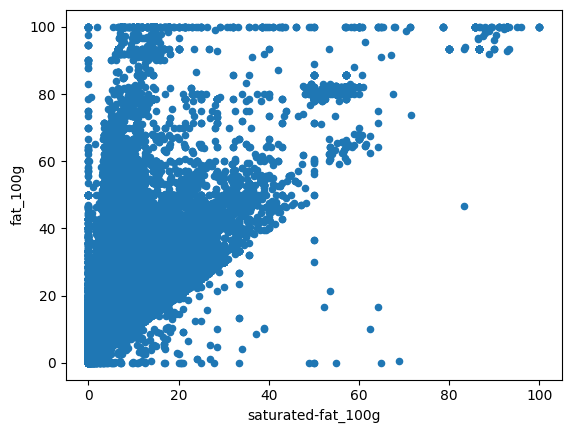

In [32]:
tmp.plot.scatter(x = "saturated-fat_100g", y = "fat_100g")

In [33]:
tmp["saturated-fat_100g"]  = np.where(tmp["saturated-fat_100g"] >= tmp["fat_100g"] , np.nan, tmp["saturated-fat_100g"])

In [34]:
tmp["trans-fat_100g"]  = np.where(tmp["trans-fat_100g"] >= tmp["fat_100g"] , np.nan, tmp["trans-fat_100g"])

In [35]:
tmp["cholesterol_100g"]  = np.where(tmp["cholesterol_100g"] >= tmp["fat_100g"] , np.nan, tmp["cholesterol_100g"])

### <a id='toc7_3_2_'></a>[Les sucres](#toc0_)

In [36]:
tmp.columns

Index(['product_name', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g',
       'iron_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'],
      dtype='object')

<AxesSubplot: xlabel='sugars_100g', ylabel='carbohydrates_100g'>

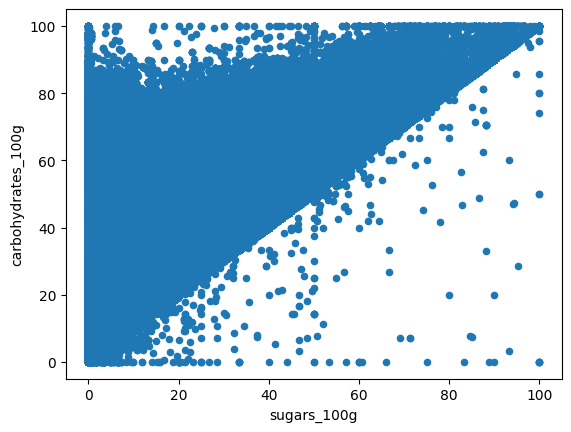

In [37]:
tmp.plot.scatter(x = "sugars_100g", y = "carbohydrates_100g")

In [38]:
tmp["sugars_100g"]  = np.where(tmp["sugars_100g"] >= tmp["carbohydrates_100g"] , np.nan, tmp["sugars_100g"])

### <a id='toc7_3_3_'></a>[Nombre de NaN par indice](#toc0_)
On va conserver uniquement les produits pour lesquels on a au maximum la moitié de valeurs manquantes

In [39]:
len(tmp.iloc[:,2:-2].columns)

14

In [40]:
tmp = tmp[tmp.iloc[:,2:-2].isnull().sum(axis = 1) < 8]
tmp.shape

(127183, 18)

### <a id='toc7_3_4_'></a>[Scale data](#toc0_)

In [41]:
for a in range(tmp.shape[1]):
    if a > 0:
        tmp.iloc[:, a] = scaleVector(tmp.iloc[:, a])

C:\Users\SSosa\AppData\Local\Temp\ipykernel_19640\1243389239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.iloc[:, a] = scaleVector(tmp.iloc[:, a])


## <a id='toc7_4_'></a>[Imputation des valeurs manquantes par KNN (la fonction prend en moyenne 15 minutes)](#toc0_)

In [42]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
tmp.iloc[:,1:] = imputer.fit_transform(tmp.iloc[:,1:])

C:\Users\SSosa\AppData\Local\Temp\ipykernel_19640\1197512381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.iloc[:,1:] = imputer.fit_transform(tmp.iloc[:,1:])


Sauvegarde du modèle

In [43]:
dataKNN = open("dataKNN.pickle", "wb")
pickle.dump(tmp, dataKNN)
dataKNN.close()